In [160]:
import pandas as pd
import geopy.distance
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapely.wkt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.prepared import prep
from sklearn.linear_model import LinearRegression
from scipy import stats

#### Get borders of vienna and create grid on them

In [2]:
vienna_border = pd.read_csv("data/LANDESGRENZEOGD.csv")

def create_polygon(x):
    x['Polygon'] = shapely.wkt.loads(x['SHAPE'])
    return x

vienna_border = vienna_border.apply(lambda x: create_polygon(x), axis=1)
vienna_border.drop("SHAPE", inplace=True, axis=1)
vienna_border.head()

,FID,OBJECTID,NAME_LANDK,NAME_LANDG,NAME_GEMK,NAME_GEMG,STATAUSTRIA_LAND_KENN,STATAUSTRIA_GEM_KENN,STATAUSTRIA_BEZ_KENN,STATAUSTRIA_BEZ_CODE,FLAECHE,UMFANG,LU_DATE,SE_ANNO_CAD_DATA,Polygon
0,LANDESGRENZEOGD.10881,10881,Wien,WIEN,Stadt Wien,STADT WIEN,9,90001,900,900,4.148711e+08,136475.45,2022-08-26,NaN,POLYGON ((16.437761721115034 48.31681098205513...


In [3]:
# stolen from https://www.matecdev.com/posts/shapely-polygon-gridding.html
def grid_bounds(geom, delta):
    minx, miny, maxx, maxy = geom.bounds
    nx = int((maxx - minx)/delta)
    ny = int((maxy - miny)/delta)
    gx, gy = np.linspace(minx,maxx,nx), np.linspace(miny,maxy,ny)
    grid = []
    for i in range(len(gx)-1):
        for j in range(len(gy)-1):
            poly_ij = Polygon([[gx[i],gy[j]],[gx[i],gy[j+1]],[gx[i+1],gy[j+1]],[gx[i+1],gy[j]]])
            grid.append( poly_ij )
    return grid
def partition(geom, delta):
    prepared_geom = prep(geom)
    grid = list(filter(prepared_geom.intersects, grid_bounds(geom, delta)))
    return grid

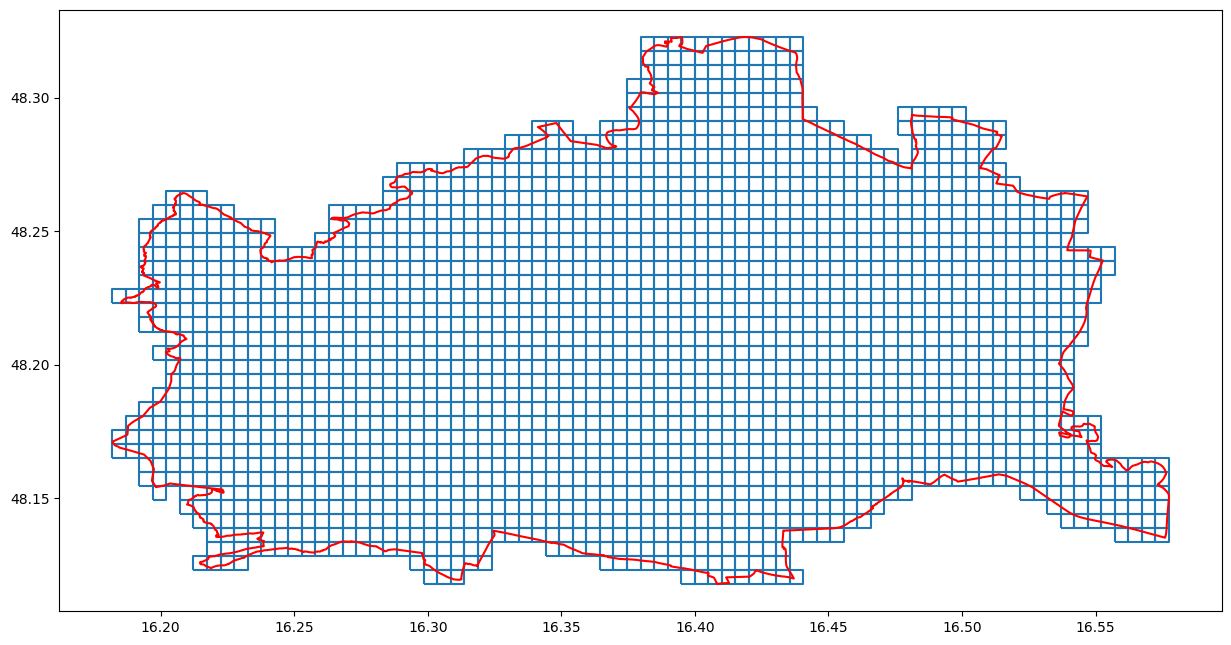

In [4]:
geom = vienna_border.Polygon[0]
grid = partition(geom, 0.005)

fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(grid).boundary.plot(ax=ax)
gpd.GeoSeries([geom]).boundary.plot(ax=ax,color="red")
plt.show()

#### Check whether data points are in grid

In [5]:
listings = pd.read_csv("data/listings.csv")
listings_cleaned = listings[["id", "name", "neighbourhood_cleansed", "latitude", "longitude", "property_type",
                             "room_type", "accommodates", "bedrooms", "price","number_of_reviews",
                             "review_scores_rating", "review_scores_location", "reviews_per_month"]]
listings_cleaned = listings_cleaned.dropna()
listings_cleaned['price'] = listings_cleaned['price'].str.extract('(\d+)', expand=False)
listings_cleaned[['price']] = listings_cleaned[['price']].apply(pd.to_numeric)
listings_cleaned[['accommodates']] = listings_cleaned[['accommodates']].apply(pd.to_numeric)
listings_cleaned['price_per_person'] = listings_cleaned['price']/listings_cleaned['accommodates']

In [6]:
def create_point(x, from_shape=True, column1 = None, column2 = None):
    if from_shape:
        x['Point'] = shapely.wkt.loads(x['SHAPE'])
    else:
        x['Point'] = Point(x[column1], x[column2])
    return x

listings_cleaned = listings_cleaned.apply(lambda x: create_point(x, from_shape=False, column1='longitude', column2='latitude'), axis=1)

In [7]:
def inside_square(x, grid):
    point = x['Point']
    for sq_id, square in enumerate(grid):
        if square.contains(point):
            x['grid_id'] = sq_id
    return x

grid_listings = listings_cleaned.apply(lambda x: inside_square(x, grid), axis=1)

In [8]:
grid_listings.head()

,Point,accommodates,bedrooms,grid_id,id,latitude,longitude,name,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_location,review_scores_rating,reviews_per_month,room_type
0,POINT (16.42767 48.24262),3,1.0,1364.0,15883,48.24262,16.42767,b&b near Old Danube river,Donaustadt,14,$110.00,Room in bed and breakfast,4.71,4.71,0.15,Hotel room
1,POINT (16.37831 48.21924),5,1.0,976.0,38768,48.21924,16.37831,central cityapartement- wifi- nice neighbourhood,Leopoldstadt,350,$69.00,Entire rental unit,4.75,4.75,2.50,Entire home/apt
2,POINT (16.32701 48.18434),6,2.0,665.0,40625,48.18434,16.32701,"Near Palace Schönbrunn, Apt. 1",Rudolfsheim-Fnfhaus,181,$145.00,Entire rental unit,4.59,4.83,1.23,Entire home/apt
3,POINT (16.37161 48.21496),2,1.0,943.0,392757,48.21496,16.37161,VCA3 Palais Brambilla - studio with city views,Innere Stadt,100,$100.00,Entire rental unit,4.89,4.64,0.79,Entire home/apt
5,POINT (16.37282 48.21351),2,1.0,943.0,392905,48.21351,16.37282,City Apartment 1- Palais Brambilla romantic style,Innere Stadt,52,$99.00,Entire rental unit,4.88,4.63,0.43,Entire home/apt


In [9]:
stations = pd.read_csv("data/HALTESTELLEWLOGD.csv")
stations = stations.apply(lambda x: create_point(x), axis=1)
stations.drop("SHAPE", inplace=True, axis=1)

In [10]:
grid_stations = stations.apply(lambda x: inside_square(x, grid), axis=1)

In [11]:
grid_stations.head()

,BEZEICHNUNG,FID,OBJECTID,Point,SE_ANNO_CAD_DATA,WL_NUMMER,grid_id
0,Absberggasse,HALTESTELLEWLOGD.1,1,POINT (16.389770011932953 48.17379006621729),NaN,1,1040.0
1,Achengasse,HALTESTELLEWLOGD.2,2,POINT (16.448900012566884 48.2845300657776),NaN,2,1515.0
2,Ada-Christen-Gasse,HALTESTELLEWLOGD.3,3,POINT (16.38581001194899 48.15293006544885),NaN,3,1036.0
3,Adam-Betz-Gasse,HALTESTELLEWLOGD.4,4,POINT (16.535120013111975 48.21564006599573),NaN,4,1944.0
4,Adamovichgasse,HALTESTELLEWLOGD.5,5,POINT (16.337990012520667 48.142290065576454),NaN,5,714.0


In [12]:
tourism = pd.read_csv("data/WIENTOURISMUSOGD.csv")
toursim_cleaned = tourism[['NAME','POSTALCODE', 'CATEGORY_NAME','SUBCATEGORY_NAME', 'GEOLAT', 'GEOLONG']]
remove_cats = ['Hotel', 'Pension', 'Appartement', 'Saisonhotel']
toursim_cleaned = toursim_cleaned[~toursim_cleaned['SUBCATEGORY_NAME'].isin(remove_cats)]
toursim_cleaned.head()

,NAME,POSTALCODE,CATEGORY_NAME,SUBCATEGORY_NAME,GEOLAT,GEOLONG
0,Porzellan,1090,"Essen, Trinken & Nightlife",Restaurant,48.219222,16.364447
1,Postamt 1150 Wien,1150,Infrastruktur,Sonstiges,48.195808,16.338125
2,Prater Alm,1020,"Essen, Trinken & Nightlife",Gasthaus & Beisl,48.215450,16.402072
3,Pratermuseum,1020,Sightseeing,Museum,48.216236,16.394952
4,Praterturm,1020,Sightseeing,Sehenswürdigkeit,48.216727,16.398029


In [13]:
toursim_cleaned = toursim_cleaned.apply(lambda x: create_point(x, from_shape=False, column1='GEOLONG', column2='GEOLAT'), axis=1)
toursim_cleaned.head()

,NAME,POSTALCODE,CATEGORY_NAME,SUBCATEGORY_NAME,GEOLAT,GEOLONG,Point
0,Porzellan,1090,"Essen, Trinken & Nightlife",Restaurant,48.219222,16.364447,POINT (16.3644467 48.2192221)
1,Postamt 1150 Wien,1150,Infrastruktur,Sonstiges,48.195808,16.338125,POINT (16.3381246 48.195808)
2,Prater Alm,1020,"Essen, Trinken & Nightlife",Gasthaus & Beisl,48.215450,16.402072,POINT (16.4020719 48.2154501)
3,Pratermuseum,1020,Sightseeing,Museum,48.216236,16.394952,POINT (16.3949522 48.2162356)
4,Praterturm,1020,Sightseeing,Sehenswürdigkeit,48.216727,16.398029,POINT (16.3980286 48.2167269)


In [77]:
grid_tourism = toursim_cleaned.apply(lambda x: inside_square(x, grid), axis=1)
grid_tourism.head()

,NAME,POSTALCODE,CATEGORY_NAME,SUBCATEGORY_NAME,GEOLAT,GEOLONG,Point,grid_id
0,Porzellan,1090,"Essen, Trinken & Nightlife",Restaurant,48.219222,16.364447,POINT (16.3644467 48.2192221),881
1,Postamt 1150 Wien,1150,Infrastruktur,Sonstiges,48.195808,16.338125,POINT (16.3381246 48.195808),724
2,Prater Alm,1020,"Essen, Trinken & Nightlife",Gasthaus & Beisl,48.215450,16.402072,POINT (16.4020719 48.2154501),1164
3,Pratermuseum,1020,Sightseeing,Museum,48.216236,16.394952,POINT (16.3949522 48.2162356),1125
4,Praterturm,1020,Sightseeing,Sehenswürdigkeit,48.216727,16.398029,POINT (16.3980286 48.2167269),1125


#### Join listing and rent

Get postal code for listings

In [14]:
grid_listings.loc[:,'neighbourhood_cleansed'] = grid_listings.loc[:,'neighbourhood_cleansed'].apply(
    lambda x: "Rudolfsheim-Fünfhaus" if str(x).__contains__("Rudolfsheim") else x
)
mapping = pd.read_csv("data/district_to_post.csv")
merged = grid_listings.merge(mapping, left_on="neighbourhood_cleansed", right_on="name", how="inner")
merged.head()

,Point,accommodates,bedrooms,grid_id,id,latitude,longitude,name_x,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_location,review_scores_rating,reviews_per_month,room_type,name_y,post
0,POINT (16.42767 48.24262),3,1.0,1364.0,15883,48.24262,16.42767,b&b near Old Danube river,Donaustadt,14,$110.00,Room in bed and breakfast,4.71,4.71,0.15,Hotel room,Donaustadt,1220
1,POINT (16.41152 48.23549),3,1.0,1246.0,846009,48.23549,16.41152,"Nice, clean and perfect location Ap",Donaustadt,72,$60.00,Entire condo,4.86,4.77,0.61,Entire home/apt,Donaustadt,1220
2,POINT (16.44955 48.22707),2,1.0,1504.0,1384870,48.22707,16.44955,Nice bedroom in sweet apartment!,Donaustadt,92,$34.00,Private room in rental unit,4.59,4.60,0.83,Private room,Donaustadt,1220
3,POINT (16.51765 48.21659),4,1.0,1876.0,3217556,48.21659,16.51765,Apartment Vienna B,Donaustadt,17,$76.00,Entire rental unit,4.65,4.76,0.51,Entire home/apt,Donaustadt,1220
4,POINT (16.51957 48.217),4,1.0,1876.0,3239235,48.21700,16.51957,Apartment Vienna A,Donaustadt,19,$76.00,Entire rental unit,4.89,4.79,0.19,Entire home/apt,Donaustadt,1220


In [15]:
merged.drop(["neighbourhood_cleansed", "name_y"], inplace=True, axis=1)
merged.rename({"name_x":"name"}, inplace=True, axis=1)
grid_listings = merged
grid_listings.head()

,Point,accommodates,bedrooms,grid_id,id,latitude,longitude,name,number_of_reviews,price,property_type,review_scores_location,review_scores_rating,reviews_per_month,room_type,post
0,POINT (16.42767 48.24262),3,1.0,1364.0,15883,48.24262,16.42767,b&b near Old Danube river,14,$110.00,Room in bed and breakfast,4.71,4.71,0.15,Hotel room,1220
1,POINT (16.41152 48.23549),3,1.0,1246.0,846009,48.23549,16.41152,"Nice, clean and perfect location Ap",72,$60.00,Entire condo,4.86,4.77,0.61,Entire home/apt,1220
2,POINT (16.44955 48.22707),2,1.0,1504.0,1384870,48.22707,16.44955,Nice bedroom in sweet apartment!,92,$34.00,Private room in rental unit,4.59,4.60,0.83,Private room,1220
3,POINT (16.51765 48.21659),4,1.0,1876.0,3217556,48.21659,16.51765,Apartment Vienna B,17,$76.00,Entire rental unit,4.65,4.76,0.51,Entire home/apt,1220
4,POINT (16.51957 48.217),4,1.0,1876.0,3239235,48.21700,16.51957,Apartment Vienna A,19,$76.00,Entire rental unit,4.89,4.79,0.19,Entire home/apt,1220


Join rent_buy with listings

In [18]:
rent_buy = pd.read_csv("data/rent_buy.csv")
grid_listings = grid_listings.merge(rent_buy, on='post', how="left")
grid_listings.head()

,Point,accommodates,bedrooms,grid_id,id,latitude,longitude,name,number_of_reviews,price,property_type,review_scores_location,review_scores_rating,reviews_per_month,room_type,post,avg_rent,avg_buy
0,POINT (16.42767 48.24262),3,1.0,1364.0,15883,48.24262,16.42767,b&b near Old Danube river,14,$110.00,Room in bed and breakfast,4.71,4.71,0.15,Hotel room,1220,16.72,6668.69
1,POINT (16.41152 48.23549),3,1.0,1246.0,846009,48.23549,16.41152,"Nice, clean and perfect location Ap",72,$60.00,Entire condo,4.86,4.77,0.61,Entire home/apt,1220,16.72,6668.69
2,POINT (16.44955 48.22707),2,1.0,1504.0,1384870,48.22707,16.44955,Nice bedroom in sweet apartment!,92,$34.00,Private room in rental unit,4.59,4.60,0.83,Private room,1220,16.72,6668.69
3,POINT (16.51765 48.21659),4,1.0,1876.0,3217556,48.21659,16.51765,Apartment Vienna B,17,$76.00,Entire rental unit,4.65,4.76,0.51,Entire home/apt,1220,16.72,6668.69
4,POINT (16.51957 48.217),4,1.0,1876.0,3239235,48.21700,16.51957,Apartment Vienna A,19,$76.00,Entire rental unit,4.89,4.79,0.19,Entire home/apt,1220,16.72,6668.69


In [19]:
empty_sq = []
grid_id_list = list(grid_listings['grid_id'])
for idx, sq in enumerate(grid):
    if idx not in grid_id_list:
        empty_sq.append(idx)
print(len(empty_sq))

1482


In [30]:
len(grid)
empty_plot_grid = [grid[i] for i in empty_sq]
plot_grid = list(set(grid)-set(empty_plot_grid))

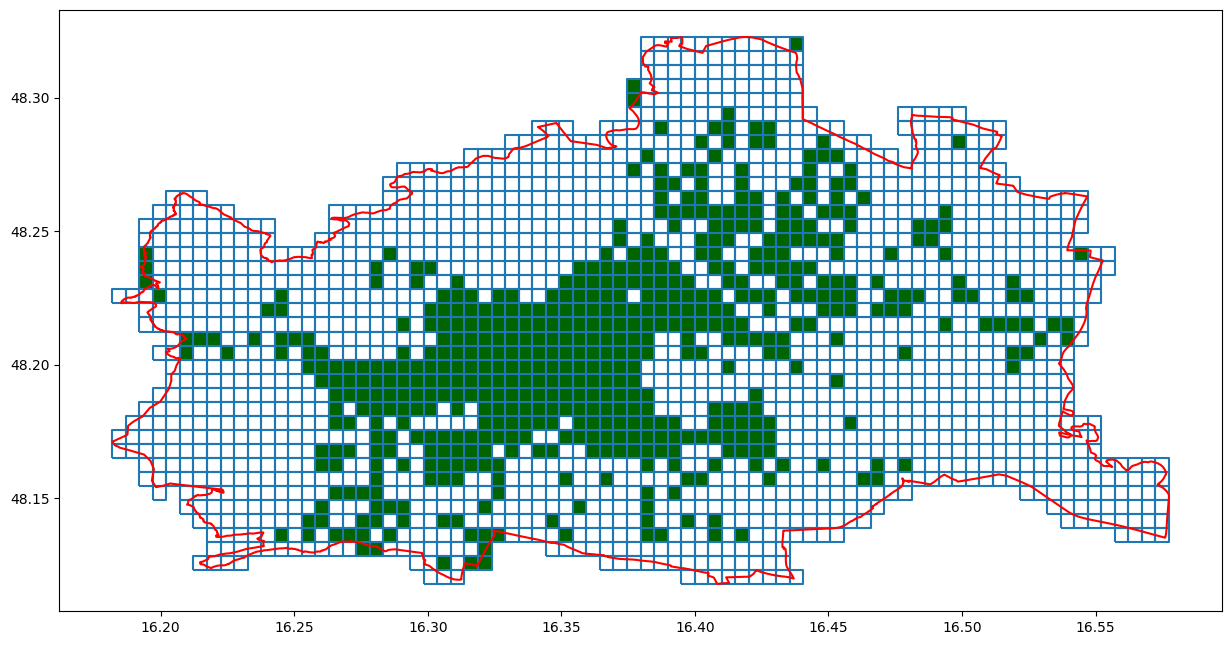

In [33]:
fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(empty_plot_grid).boundary.plot(ax=ax)
gpd.GeoSeries(plot_grid).boundary.plot(ax=ax, facecolor="darkgreen")
gpd.GeoSeries([geom]).boundary.plot(ax=ax,color="red")
plt.show()

#### Filter grid

In [52]:
relevant_squares = grid_listings.groupby("grid_id").filter(lambda x: len(x) > 4).sort_values("grid_id")["grid_id"].unique().tolist()
relevant_grid = [grid[int(i)] for i in relevant_squares]

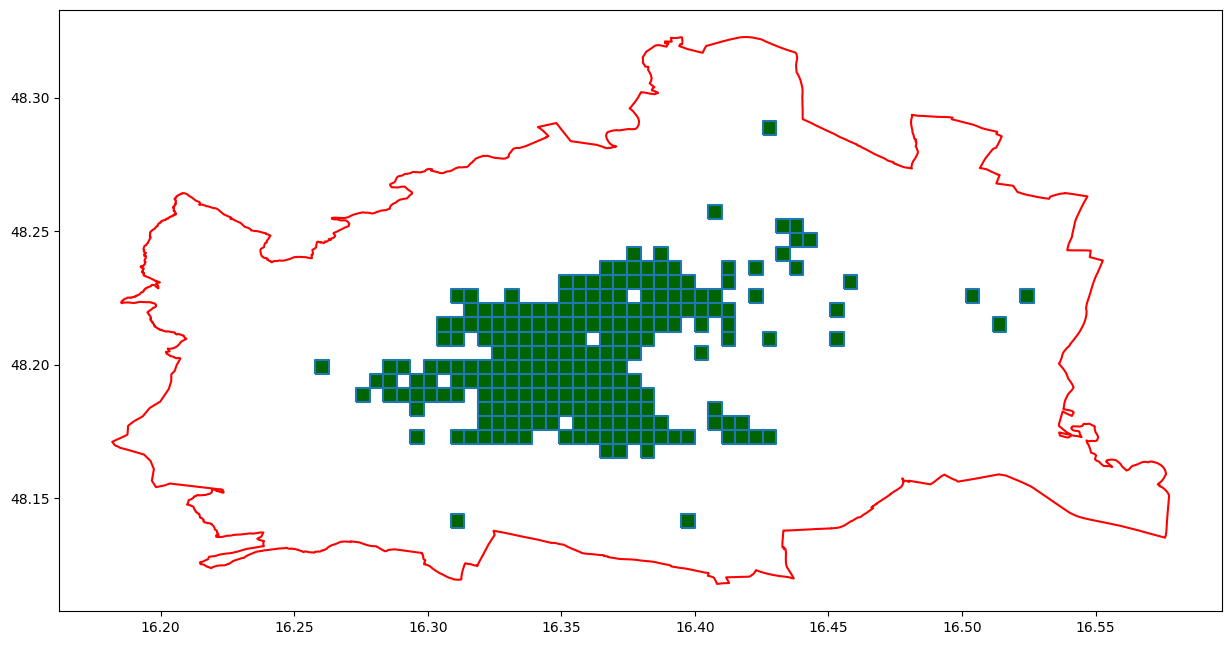

In [53]:
fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(relevant_grid).boundary.plot(ax=ax, facecolor="darkgreen")
gpd.GeoSeries([geom]).boundary.plot(ax=ax,color="red")
plt.show()

In [84]:
best_grid_id = grid_listings["grid_id"].mode().max()

#### Create Model data frame

In [111]:
model_data = grid_listings[grid_listings["grid_id"] == best_grid_id]
model_data=model_data.astype({"grid_id":int})

tourism_model = grid_tourism[grid_tourism["grid_id"] == best_grid_id]

In [129]:
grid_stations.head()

,BEZEICHNUNG,FID,OBJECTID,Point,SE_ANNO_CAD_DATA,WL_NUMMER,grid_id
0,Absberggasse,HALTESTELLEWLOGD.1,1,POINT (16.389770011932953 48.17379006621729),NaN,1,1040.0
1,Achengasse,HALTESTELLEWLOGD.2,2,POINT (16.448900012566884 48.2845300657776),NaN,2,1515.0
2,Ada-Christen-Gasse,HALTESTELLEWLOGD.3,3,POINT (16.38581001194899 48.15293006544885),NaN,3,1036.0
3,Adam-Betz-Gasse,HALTESTELLEWLOGD.4,4,POINT (16.535120013111975 48.21564006599573),NaN,4,1944.0
4,Adamovichgasse,HALTESTELLEWLOGD.5,5,POINT (16.337990012520667 48.142290065576454),NaN,5,714.0


In [131]:
model_data_lst = grid_listings.groupby("grid_id").agg(
    number_of_listings=("post", "count"),
    avg_rent=("avg_rent", "mean"),
    avg_buy=("avg_buy", "mean"),
    avg_location_review=("review_scores_location", "mean"),
    avg_price=("price_per_person", "mean"))
model_data_tsm = grid_tourism.groupby("grid_id").agg(
    number_different_tsm=("SUBCATEGORY_NAME", "nunique"),
    number_tsm=("grid_id", "count"))
model_data_stations = grid_stations.groupby("grid_id").agg(
    number_st=("grid_id", "count"))

In [156]:
model_data = model_data_lst.merge(model_data_tsm, on="grid_id").merge(model_data_stations, on="grid_id")
model_data.reset_index(inplace=True)

In [157]:
X = model_data.drop("number_of_listings", axis=1)
y = model_data["number_of_listings"]
X

,grid_id,avg_rent,avg_buy,avg_location_review,avg_price,number_different_tsm,number_tsm,number_st
0,234.0,17.15,5962.340,4.0000,25.000000,1,1,1
1,290.0,15.83,8201.800,4.7500,14.000000,1,1,1
2,291.0,16.94,6646.130,4.2075,19.250000,3,3,2
3,292.0,16.94,6646.130,5.0000,10.000000,1,1,1
4,302.0,17.15,5962.340,4.9200,14.000000,1,1,3
...,...,...,...,...,...,...,...,...
235,1535.0,16.72,6668.690,4.6250,30.000000,2,2,1
236,1540.0,16.72,6668.690,4.6700,45.000000,1,1,2
237,1541.0,15.97,6217.715,4.7650,21.145833,1,1,4
238,1564.0,16.72,6668.690,4.6020,17.550000,1,1,2


In [162]:
lm = LinearRegression()
lm.fit(X,y)

LinearRegression()

## Next steps
-) Get linear regression model to work
-) Follow https://www.jla-data.net/eng/branch-network-optimization-in-r/
-) Get an intermediate result
-) Clean model
-) Repeat all done till now
-) Take a look at the todos to improve result

## TODOS and Ideas:
-) Take neighboring grid squares for transport stations and tourism points, decrease square size
-) Think about relevant grids